## Final Project Submission

Please fill out:
* Student name: Allen Muraya Maina, Cynthia Kareko, Celiajoy Omiah, Marion Jelimo, William Omballa.
* Student pace: full time
* Scheduled project review date/time: 26th October 2023
* Instructor name: Nikita Njoroge.
* Blog post URL:


## KING COUNTY HOUSE SALES PROJECT


## Introduction

Addressing the real estate challenges in King County, Washington, demands a concerted effort from various stakeholders. In this project, we will come up with a model to help a real estate agency that will give good insights to prospective home sellers on ways they can improve the value of their home, and whether the investment is worth the cost.

# Column Names and Descriptions for King County Data Set
* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each condition code
* `grade` - Overall grade of the house. Related to the construction and design of the house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `zipcode` - ZIP Code used by the United States Postal Service
* `lat` - Latitude coordinate
* `long` - Longitude coordinate
* `sqft_living15` - The square footage of interior housing living space for the nearest 15 neighbors
* `sqft_lot15` - The square footage of the land lots of the nearest 15 neighbors


## Data understanding


The dataset used for this analysis comprises ofadministrative data on over 21,000 house sales that occurred between May 2014 and May 2015. The data contains homes with different features which include prices, the number of bedrooms, the year the homes were built including the conditions of the homes.                                              

We can import the important libraries to be used.

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_error, mean_squared_error

%matplotlib inline

Loading the dataset

In [2]:
# Load the dataset
data = pd.read_csv("./data/kc_house_data.csv")
df = data

In [3]:
def display_df_info(df):
    # Show the list of columns in the DataFrame
    print("DataFrame Columns:")
    print(df.columns.tolist())
    print("\n")

    # Show the first 5 rows (head) of the DataFrame
    print("DataFrame Head:")
    print(df.head())
    print("\n")

    # Show the shape of the DataFrame
    print("DataFrame Shape:")
    print(df.shape)
    print("\n")

    # Show info about the DataFrame
    print("DataFrame Info:")
    print(df.info())
    print("\n")

    #Show summary statistics of numeric columns
    print("DataFrame Description:")
    print(df.describe())

In [4]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [5]:
# Selecting relevant columns for our analysis 
data.drop("id", axis=1, inplace=True)
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


Looking into the the descriptive statistics that summarizes the central tendency, dispersion and shape of the dataset’s distribution.

C:\Users\hp\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Skewness: 4.023365
Kurtosis: 34.541359


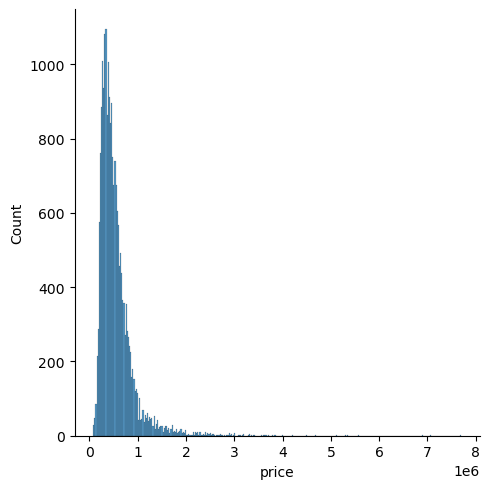

In [6]:
sns.displot(df.price)
print("Skewness: %f" % df.price.skew())
print("Kurtosis: %f" % df.price.kurt())

Normalize the price through log transformations and scale it to facilitate its modelling.

In [7]:
mean_house_price = df.price.mean()#will be used later
df["price"] = np.log(df["price"])
m=df.price.mean()
std=df.price.std()
df.price = (df.price - m) / std

C:\Users\hp\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


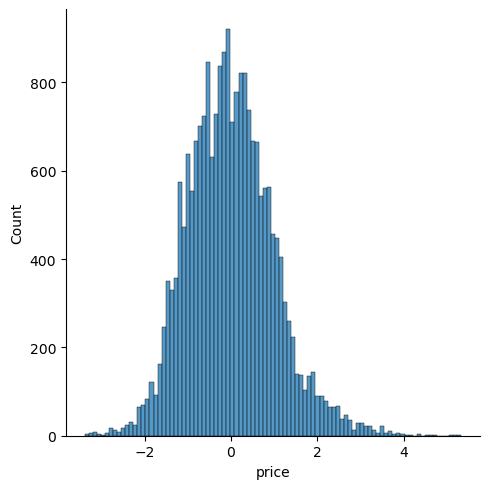

In [8]:
sns.displot(df.price)

# Data Preparation

Preparation of the data involve;

Handling missing values by filling in missing data points or removing rows/columns with missing values.

Remove duplicates where we eliminate duplicate records to maintain data integrity.

Correct inaccuracies by identifying and correcting errors or inconsistencies in the data.

Handling outliers by Analyzing and decide whether to remove or transform outliers based on the context of the analysis.

Dealing with the categorical values in our dataset and whether they require One-Hot encoding

Does the dataset provided require any transformation

### Null Values

In [9]:
# Dropping null values
df.dropna(subset='waterfront', inplace=True)
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1,12/9/2014,0.279938,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2/25/2015,-1.799430,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,12/9/2014,0.499698,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,2/18/2015,0.178434,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
5,5/12/2014,1.850356,4,4.50,5420,101930,1.0,NO,NONE,Average,11 Excellent,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19221 entries, 1 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           19221 non-null  object 
 1   price          19221 non-null  float64
 2   bedrooms       19221 non-null  int64  
 3   bathrooms      19221 non-null  float64
 4   sqft_living    19221 non-null  int64  
 5   sqft_lot       19221 non-null  int64  
 6   floors         19221 non-null  float64
 7   waterfront     19221 non-null  object 
 8   view           19164 non-null  object 
 9   condition      19221 non-null  object 
 10  grade          19221 non-null  object 
 11  sqft_above     19221 non-null  int64  
 12  sqft_basement  19221 non-null  object 
 13  yr_built       19221 non-null  int64  
 14  yr_renovated   15809 non-null  float64
 15  zipcode        19221 non-null  int64  
 16  lat            19221 non-null  float64
 17  long           19221 non-null  float64
 18  sqft_living

(1920.0, 2018.0)

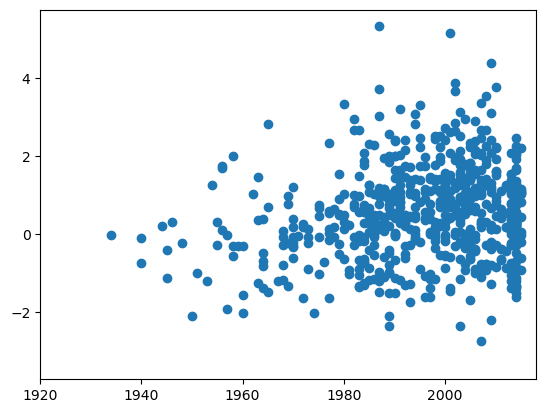

In [11]:
plt.scatter(df.yr_renovated, df.price)
plt.xlim(1920,2018)

### Duplicates

In [12]:
# Checking for duplicate data
def check_duplicates(column):
    return column.duplicated().value_counts()

dups = check_duplicates(df)
dups


False    19221
Name: count, dtype: int64

In [13]:
# Dropping duplicate rows
df = df.drop_duplicates()

In [14]:
#checking the shape after dropping the duplicates
df.shape

(19221, 20)

In [15]:
#checking the statistical summary
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,19221.000000,19221.000000,19221.000000,19221.000000,1.922100e+04,19221.000000,19221.000000,19221.000000,15809.000000,19221.000000,19221.000000,19221.000000,19221.000000,19221.000000
mean,0.002575,3.374642,2.117072,2082.420894,1.507376e+04,1.495031,1791.366058,1971.039800,82.321336,98077.736382,47.559923,-122.214042,1987.375943,12806.692108
std,1.001615,0.928539,0.769576,922.544859,4.081729e+04,0.540155,831.727580,29.384666,396.938189,53.456300,0.138692,0.140728,684.723981,27576.842373
min,-3.387580,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,-0.694902,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1200.000000,1951.000000,0.000000,98033.000000,47.470700,-122.328000,1490.000000,5100.000000
50%,-0.059268,3.000000,2.250000,1920.000000,7.620000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571900,-122.231000,1840.000000,7620.000000
75%,0.621480,4.000000,2.500000,2550.000000,1.071600e+04,2.000000,2220.000000,1997.000000,0.000000,98117.000000,47.678000,-122.125000,2360.000000,10092.000000
max,5.333765,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


## Drop Columns

In [16]:
df.drop(columns = ['lat', 'long'], axis =1, inplace=True)
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
1,12/9/2014,0.279938,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,1690,7639
2,2/25/2015,-1.799430,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,98028,2720,8062
3,12/9/2014,0.499698,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,1360,5000
4,2/18/2015,0.178434,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,98074,1800,7503
5,5/12/2014,1.850356,4,4.50,5420,101930,1.0,NO,NONE,Average,11 Excellent,3890,1530.0,2001,0.0,98053,4760,101930


In [17]:
#Conversion of sqft_basement
df['sqft_basement']=df['sqft_basement'].astype(str)
df.sqft_basement.replace('?', 0, inplace = True)
df.sqft_basement.apply(pd.to_numeric);
df['sqft_basement']=df['sqft_basement'].astype(float)

In [18]:
#Sort numerical data
df_numerical=pd.concat([df.sqft_living,df.sqft_living15,df.sqft_lot,df.sqft_lot15,df.yr_built,df.sqft_basement,df.sqft_above], axis=1)

In [19]:
df['view'].fillna(0, inplace=True)  # Replace missing values with 0 (or any other appropriate value).


In [20]:
views = {
    "missing": 0,
    "NONE"   : 1,
    "FAIR" :    2,
    "AVERAGE": 3,
    "GOOD"   :  4,
    "EXCELLENT" : 5
}
df["view_imputed"] = df["view"].replace(views).astype(int)

In [21]:
df['view'].value_counts()

view
NONE         17312
AVERAGE        836
GOOD           435
FAIR           291
EXCELLENT      290
0               57
Name: count, dtype: int64

In [22]:
df['condition'].value_counts()

condition
Average      12474
Good          5058
Very Good     1512
Fair           152
Poor            25
Name: count, dtype: int64

In [23]:
conditions = {
    "Poor": 0,
    "Fair"   : 1,
    "Average" :    2,
    "Good": 3,
    "Very Good"   :  4
    
}
df["House_condition"] = df["condition"].replace(conditions).astype(int)

In [24]:
#Sort Dates
df.date=pd.to_datetime(df.date, format="%m/%d/%Y");
df.date=df.date.astype(str)
df.date=df.date.map(lambda x: x[:7])


In [25]:
df['zipcode']=df['zipcode'].astype('category')

### Outliers

In [26]:
# Checking values in 'bedrooms' columns
df['bedrooms'].unique()

array([ 3,  2,  4,  5,  1,  6,  7,  8,  9, 11, 10, 33], dtype=int64)

In [27]:
# Removing outliers
df = df[df['bedrooms'] != 33]
df['bedrooms'].unique()

array([ 3,  2,  4,  5,  1,  6,  7,  8,  9, 11, 10], dtype=int64)

In [28]:
# Checking the number of rows and columns after data cleaning
df.shape

(19220, 20)

# Data analysis

The analysis likely includes data preprocessing steps, exploratory data analysis (EDA), feature selection or engineering, model training and evaluation, and, for the prediction objective, possibly model optimization and validation

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19220 entries, 1 to 21596
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   date             19220 non-null  object  
 1   price            19220 non-null  float64 
 2   bedrooms         19220 non-null  int64   
 3   bathrooms        19220 non-null  float64 
 4   sqft_living      19220 non-null  int64   
 5   sqft_lot         19220 non-null  int64   
 6   floors           19220 non-null  float64 
 7   waterfront       19220 non-null  object  
 8   view             19220 non-null  object  
 9   condition        19220 non-null  object  
 10  grade            19220 non-null  object  
 11  sqft_above       19220 non-null  int64   
 12  sqft_basement    19220 non-null  float64 
 13  yr_built         19220 non-null  int64   
 14  yr_renovated     15808 non-null  float64 
 15  zipcode          19220 non-null  category
 16  sqft_living15    19220 non-null  int64   
 17

array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'bedrooms'}>,
        <Axes: title={'center': 'bathrooms'}>,
        <Axes: title={'center': 'sqft_living'}>],
       [<Axes: title={'center': 'sqft_lot'}>,
        <Axes: title={'center': 'floors'}>,
        <Axes: title={'center': 'sqft_above'}>,
        <Axes: title={'center': 'sqft_basement'}>],
       [<Axes: title={'center': 'yr_built'}>,
        <Axes: title={'center': 'yr_renovated'}>,
        <Axes: title={'center': 'sqft_living15'}>,
        <Axes: title={'center': 'sqft_lot15'}>],
       [<Axes: title={'center': 'view_imputed'}>,
        <Axes: title={'center': 'House_condition'}>, <Axes: >, <Axes: >]],
      dtype=object)

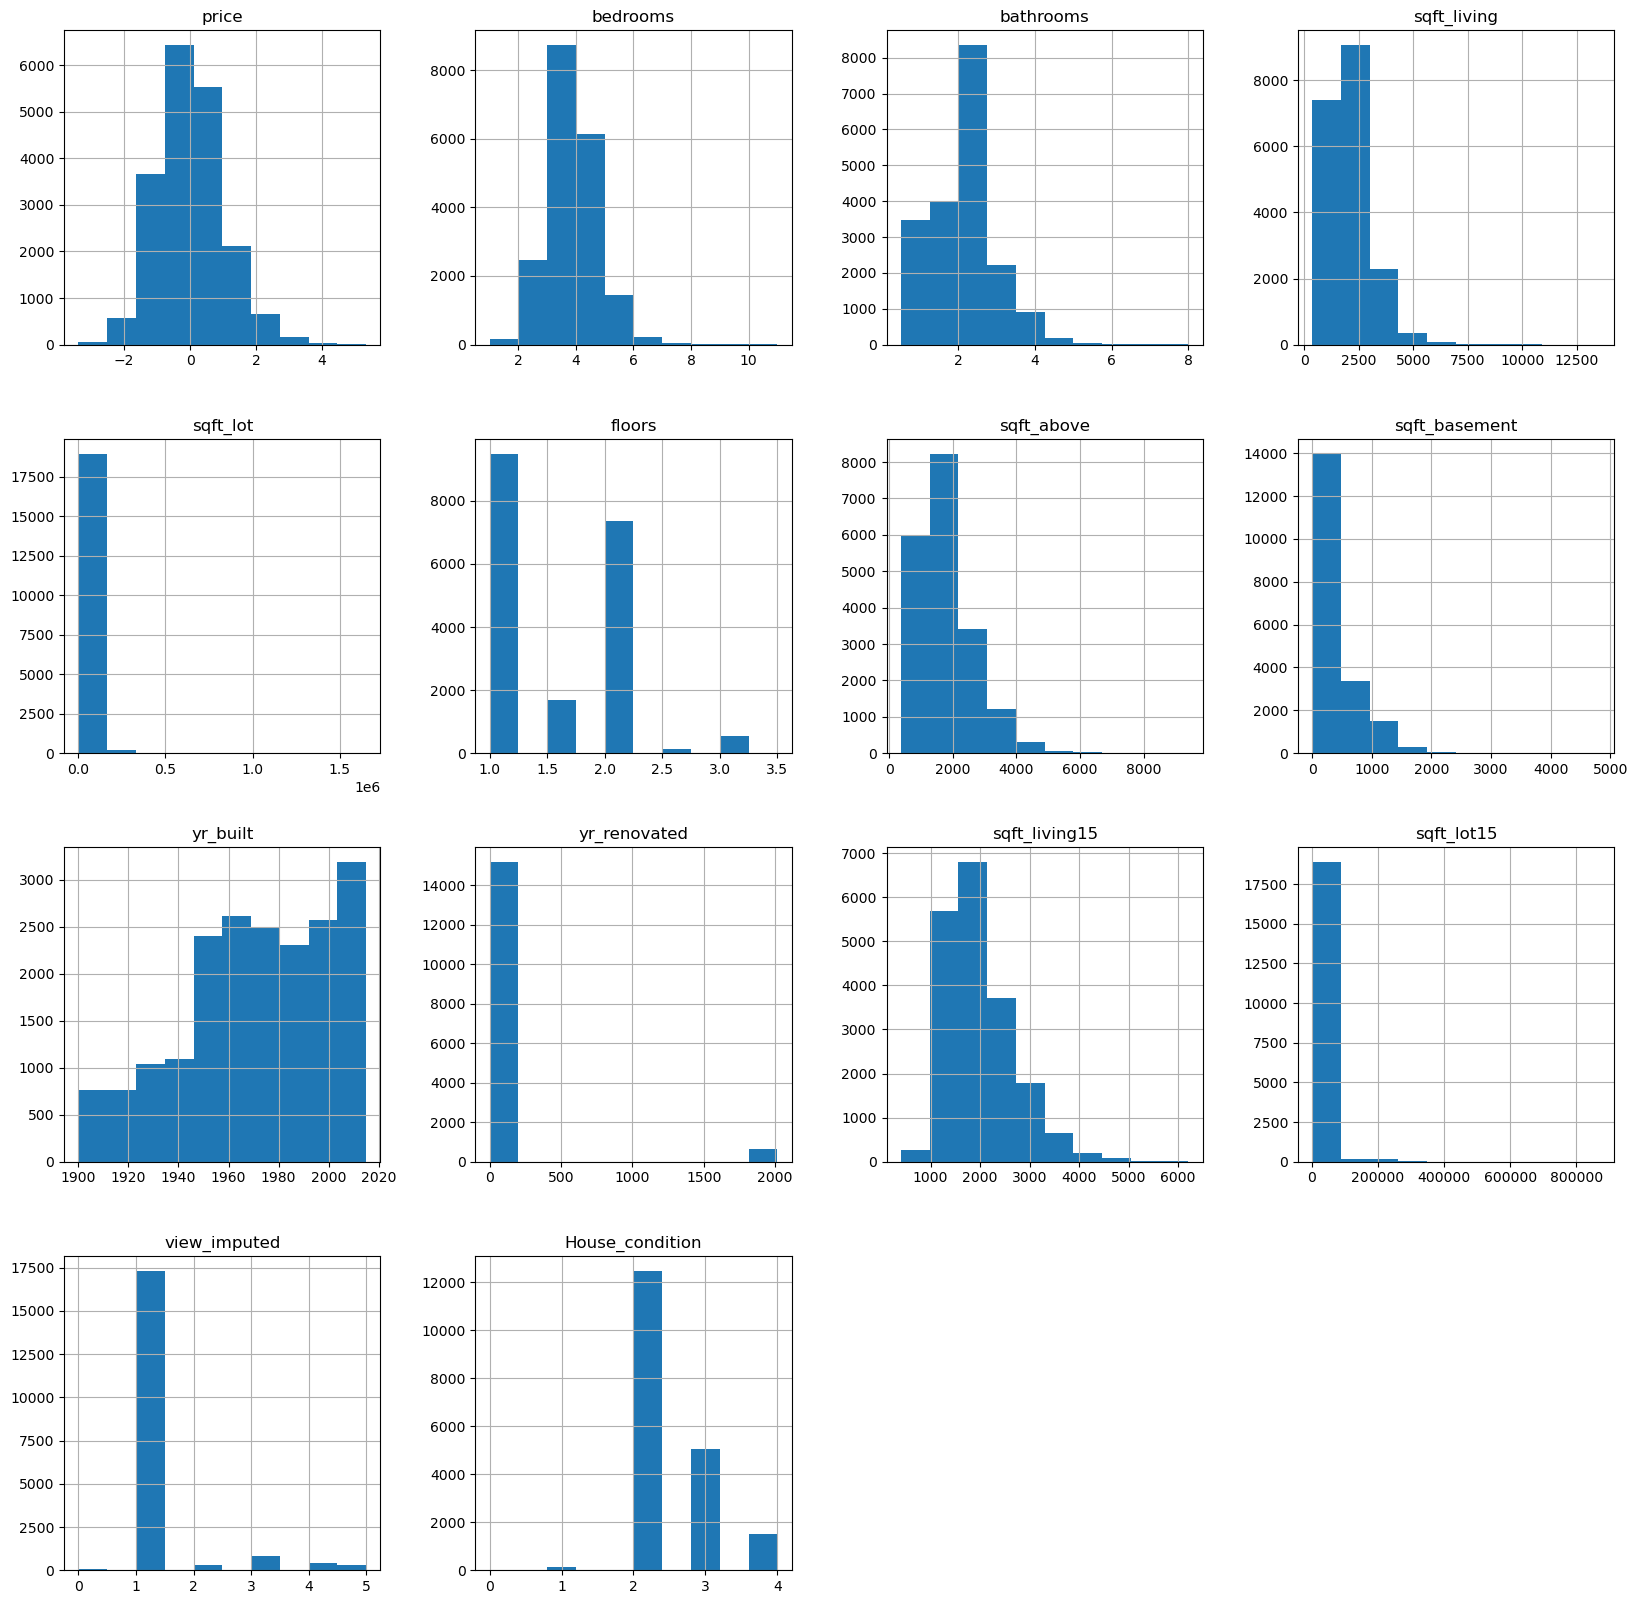

In [30]:
# Plotting a histogram for the columns in our dataset
df.hist(figsize=(20,20))

In [31]:
# Checking the values in condition.
df['condition'].unique()

array(['Average', 'Very Good', 'Good', 'Poor', 'Fair'], dtype=object)

In [32]:
# Replacing the string value with the corresponding integer value (Based on the dataset glossary)
df['condition'] = df['condition'].replace({'Poor': 1, 'Fair': 2, 'Average': 3, 'Good': 4, 'Very Good': 5})
df['condition'].unique()

array([3, 5, 4, 1, 2], dtype=int64)

In [33]:
#Checking the changes made
df['grade'].unique()

array(['7 Average', '6 Low Average', '8 Good', '11 Excellent', '9 Better',
       '5 Fair', '10 Very Good', '12 Luxury', '4 Low', '3 Poor',
       '13 Mansion'], dtype=object)

In [34]:
# Extracting the integer from the string
df['grade'] = df['grade'].str.extract('(\d+)', expand=False).astype(int)

# Checking the changes made
df['grade'].unique()

array([ 7,  6,  8, 11,  9,  5, 10, 12,  4,  3, 13])

In [35]:
# Replacing the string value with the corresponding integer value (Based on the dataset glossary)
df['waterfront'] = df['waterfront'].replace({'NO': 0, 'YES': 1})
df['waterfront'].unique()

array([0, 1], dtype=int64)

### One-Hot Encoding

In our dataset there are features that are highly related with price but a definate relationship has not been established. It can be illustrated in the following

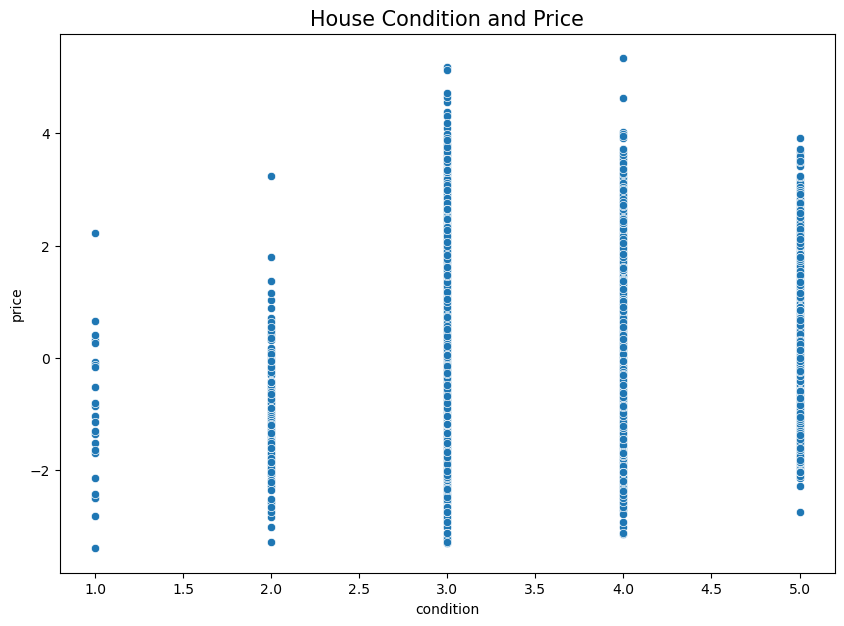

In [36]:
# Plotting the condition and price
plt.figure(figsize=(10, 7))
sns.scatterplot(x='condition', y='price', data=df)
plt.title('House Condition and Price', fontsize=15)
plt.show()

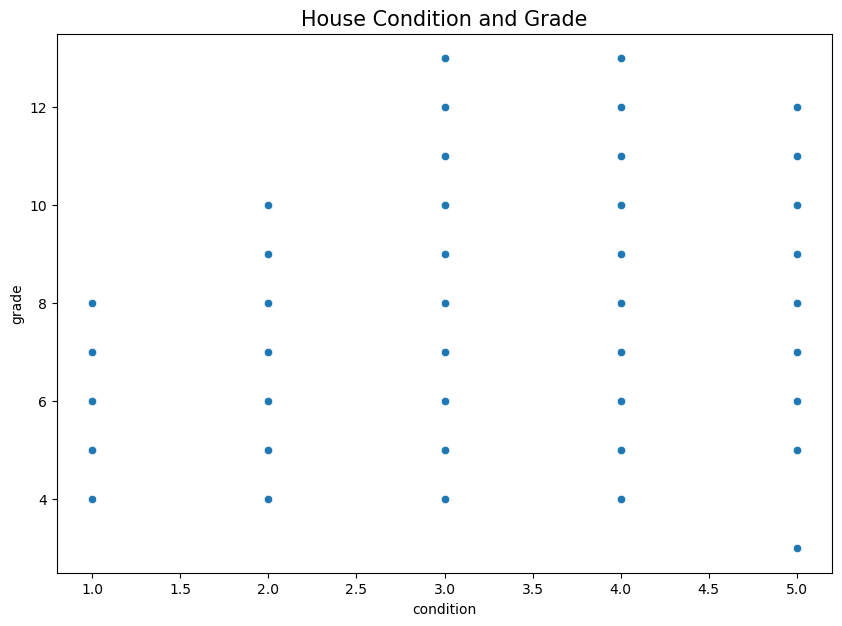

In [37]:
#Plotting the condition and grade
plt.figure(figsize=(10, 7))
sns.scatterplot(x='condition', y='grade', data=df)
plt.title('House Condition and Grade', fontsize=15)
plt.show()

Through One-Hot encoding, we can identify a better structured linear relationship between price and other features. This can be done by creating dummy variables for each feature.

In [38]:
#One-Hot Encoding
one_hot = pd.get_dummies(df['condition'], drop_first=True) #drop a column to avoid dummy variable trap
new_df = df.drop('condition',axis = 1)
new_df = df.join(one_hot)

<Figure size 640x480 with 0 Axes>

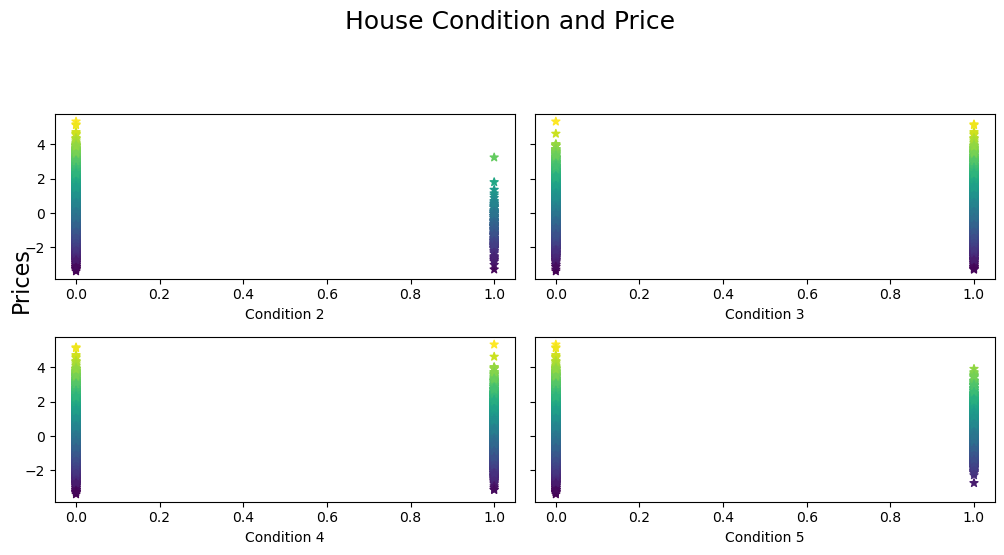

In [39]:
#Generate Scatter plots for the other features
price = new_df['price']
two = new_df['two'] = new_df[2] 
three = new_df['three'] = new_df[3] 
four = new_df['four'] = new_df[4] 
five = new_df['five'] = new_df[5] 

f = plt.figure()
f, axes = plt.subplots(nrows = 2, ncols = 2, sharex=False, sharey = True, figsize=(10,5))

f.suptitle('House Condition and Price', fontsize=18, y=1.1)
f.text(0.0001, 0.56, 'Prices', va='center', rotation='vertical', fontsize=16)

sc = axes[0][0].scatter(two, price, c = price, marker = "*")
axes[0][0].set_xlabel('Condition 2')

axes[0][1].scatter(three, price, c = price, marker = "*")
axes[0][1].set_xlabel('Condition 3')

axes[1][0].scatter(four, price, c = price, marker = "*")
axes[1][0].set_xlabel('Condition 4')

axes[1][1].scatter(five, price, c = price, marker = "*")
axes[1][1].set_xlabel('Condition 5')


f.tight_layout()
plt.show()

Condition Ratings 2 and 3 have the most defined relationship

In [40]:
# Converting the square foot to metres for easier interpretation
conversion_factor = 0.092903
new_df['sqmt_living'] = df['sqft_living'] * conversion_factor
new_df['sqmt_lot'] = df['sqft_lot'] * conversion_factor

new_df['sqmt_living'].head()

1    238.76071
2     71.53531
3    182.08988
4    156.07704
5    503.53426
Name: sqmt_living, dtype: float64

In [41]:
new_df.columns

Index([           'date',           'price',        'bedrooms',
             'bathrooms',     'sqft_living',        'sqft_lot',
                'floors',      'waterfront',            'view',
             'condition',           'grade',      'sqft_above',
         'sqft_basement',        'yr_built',    'yr_renovated',
               'zipcode',   'sqft_living15',      'sqft_lot15',
          'view_imputed', 'House_condition',                 2,
                       3,                 4,                 5,
                   'two',           'three',            'four',
                  'five',     'sqmt_living',        'sqmt_lot'],
      dtype='object')

In [42]:
#New and updated dataframe for variables
new_df.drop(columns=['sqft_lot', 'sqft_living'], inplace=True)

new_df.columns

Index([           'date',           'price',        'bedrooms',
             'bathrooms',          'floors',      'waterfront',
                  'view',       'condition',           'grade',
            'sqft_above',   'sqft_basement',        'yr_built',
          'yr_renovated',         'zipcode',   'sqft_living15',
            'sqft_lot15',    'view_imputed', 'House_condition',
                       2,                 3,                 4,
                       5,             'two',           'three',
                  'four',            'five',     'sqmt_living',
              'sqmt_lot'],
      dtype='object')

## Correlations and Multicollinearity

There is need to visualize our data through the use of a heatmap of correlations between each variable against other variables.

<Axes: title={'center': 'Correlation of features'}>

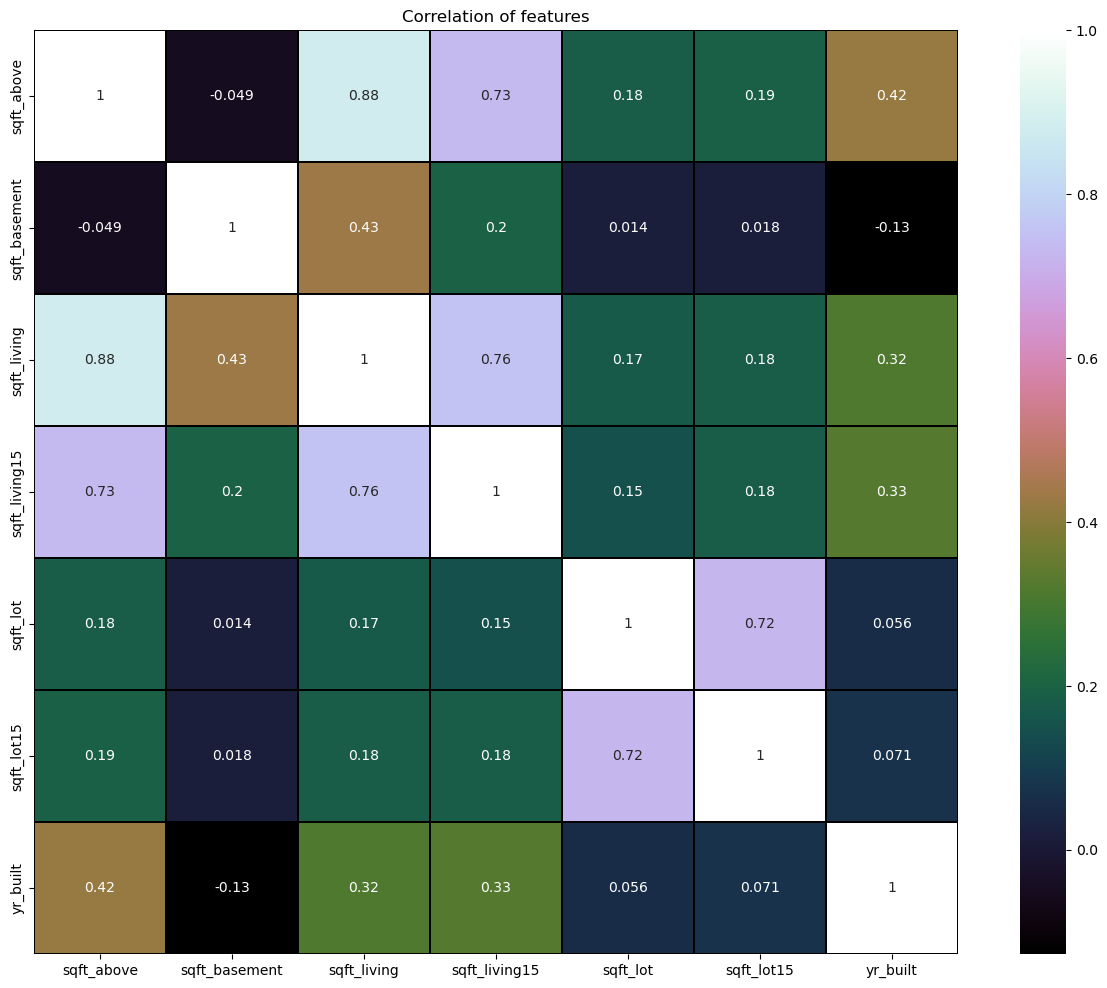

In [43]:
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in df.items():
    if type(colvalue[1]) == str:
         str_list.append(colname)
# Get to the numeric columns by inversion            
num_list = df_numerical.columns.difference(str_list) 
# Create Dataframe containing only numerical features
house_num = df_numerical[num_list]
f, ax = plt.subplots(figsize=(16, 12))
plt.title('Correlation of features')
# Draw the heatmap using seaborn
#sns.heatmap(house_num.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="PuBuGn", linecolor='k', annot=True)
sns.heatmap(house_num.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="cubehelix", linecolor='k', annot= True)

As anticipated, numerous features associated with home size such as sqft_living, sqft_living15 and sqft_above exhibit strong correlation. We tend to avoid inclusion of pairs of independent variable with correlations past 0.80 within the same model. We however include variables that demonstrate significant correlations with the dependent variable. 

## Preparing Categorical Data

In [44]:
#Converting to categorical
df.floors = df.floors.astype('category')
df.yr_built = df.yr_built.astype(float)
df.zipcode = df.zipcode.astype('category')
df.condition = df.condition.astype('category')
df.bedrooms = df.bedrooms.astype('category')
df.grade = df.grade.astype('category')
df.bathrooms = df.bathrooms.astype('category')
df['waterfront'] = df['waterfront'].astype(str).astype('category')

### Relationship between House Condition and Price

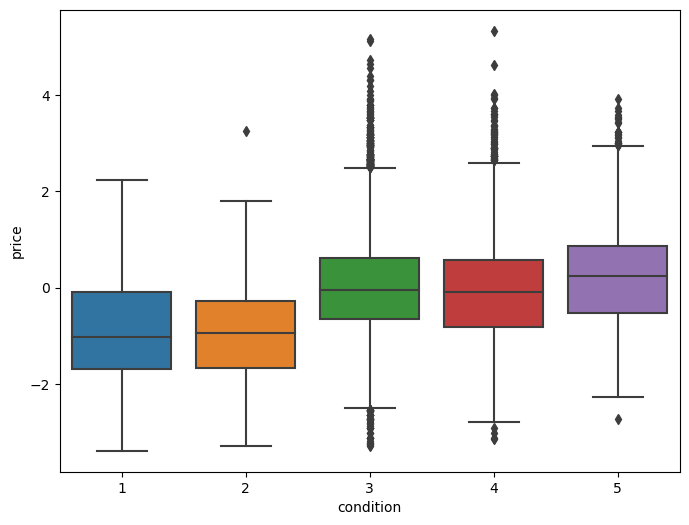

In [45]:
#Box plot for condition
var = 'condition'
data = pd.concat([df['price'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="price", data=data)

There is a slight increase in price for a condition rating of 3 or higher. This variable will be temporarily ommitted.

### Relationship between Number of Floors and Price

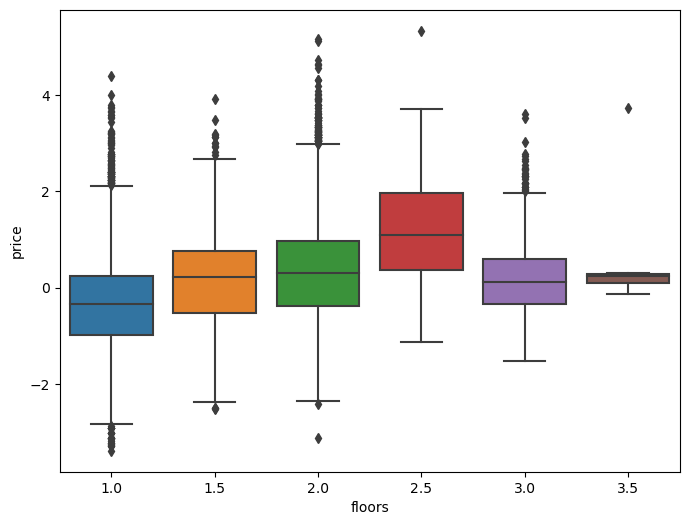

In [46]:
#Box Plot for floors
var = 'floors'
data = pd.concat([df['price'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="price", data=data)

The majority of the price appreciation is evident up to about 2.5 floors with data suggesting that beyond that, the houses become less valuable, which could be attributed to the specific location of the properties. This suggests that the value of homes increases significantly up to a certain number of floors and the gradual decrease in value may be influenced by geographical characteristics of the properties' surroundings.

### Relationship between Zipcode and price

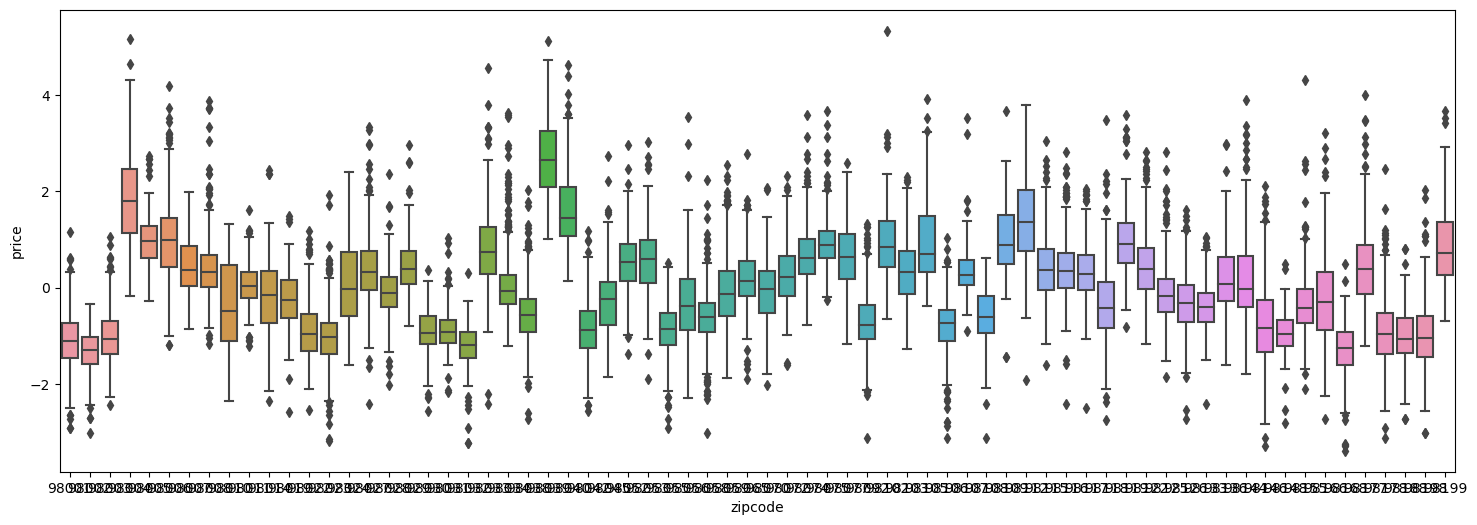

In [47]:
#Box Plot for Zipcode
var = 'zipcode'
data = pd.concat([df['price'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x=var, y="price", data=data)

As indicated by this box plot, it is evident that zipcode is one of the most influential factors affecting the price. The distribution of prices across different zipcodes reveal substantial variations in that certain zipcodes exhibit considerably higher prices.

### Relationship between Number of Bedrooms and price

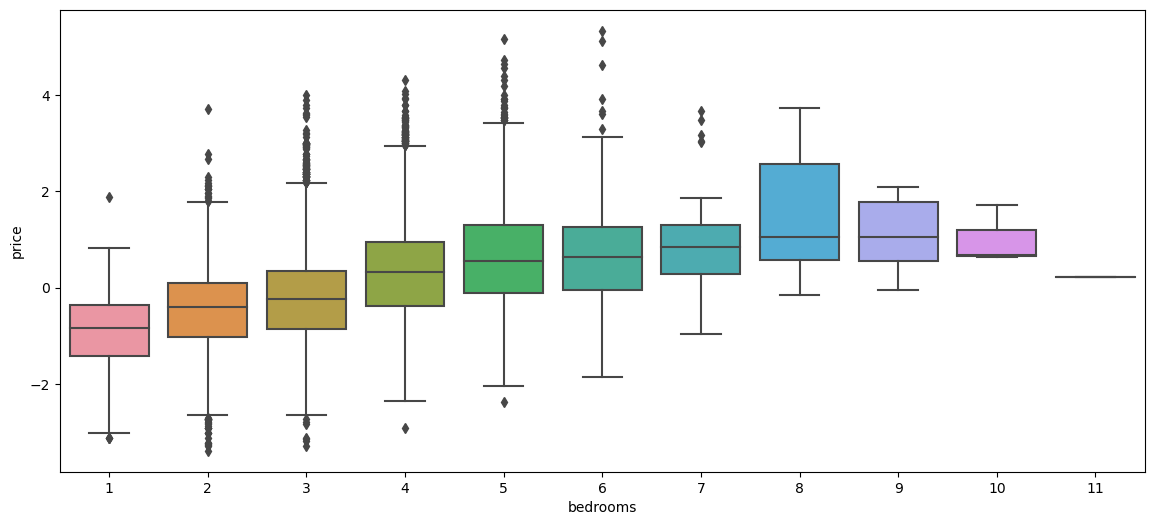

In [48]:
#Box plot for bedrooms
var = 'bedrooms'
data = pd.concat([df['price'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.boxplot(x=var, y="price", data=data)

Number of bedrooms does show an expected effect on price. However, too many bedrooms past 8 bedrooms show a steady decline.

### Relationship between Number of Bathrooms and price

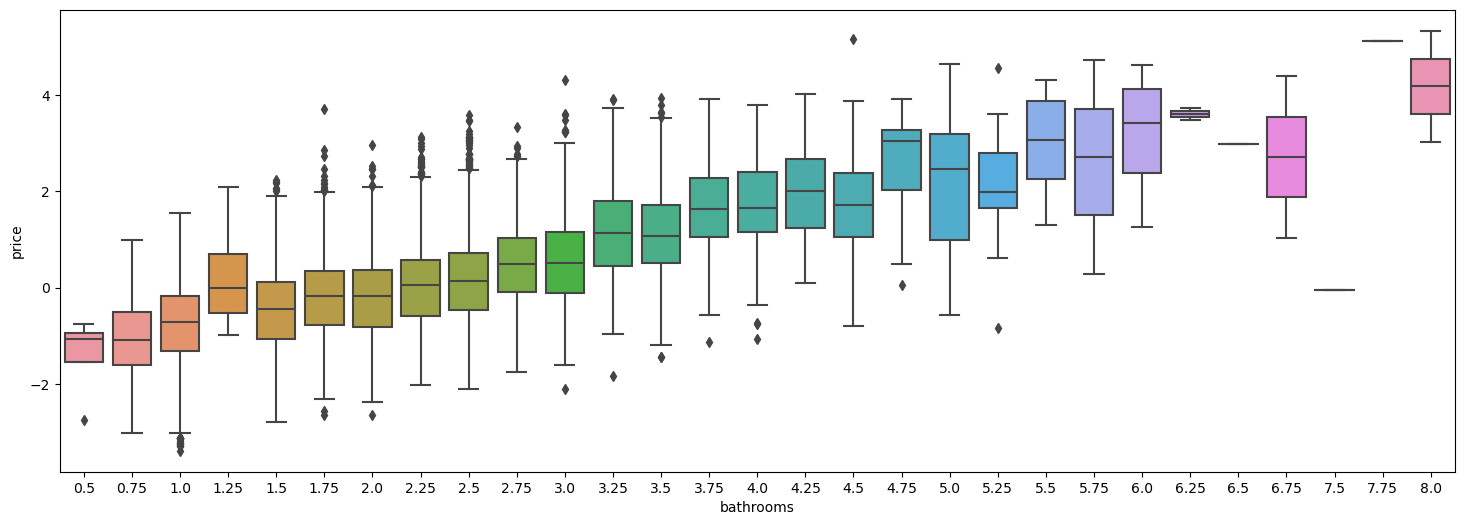

In [49]:
#Box plot for bathrooms
var = 'bathrooms'
data = pd.concat([df['price'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x=var, y="price", data=data)

Number of bathrooms show a significant impact on price as the box plot shows a steady rise of price related to subsequent increase in number of bathrooms.

### Relationship between Grade and price

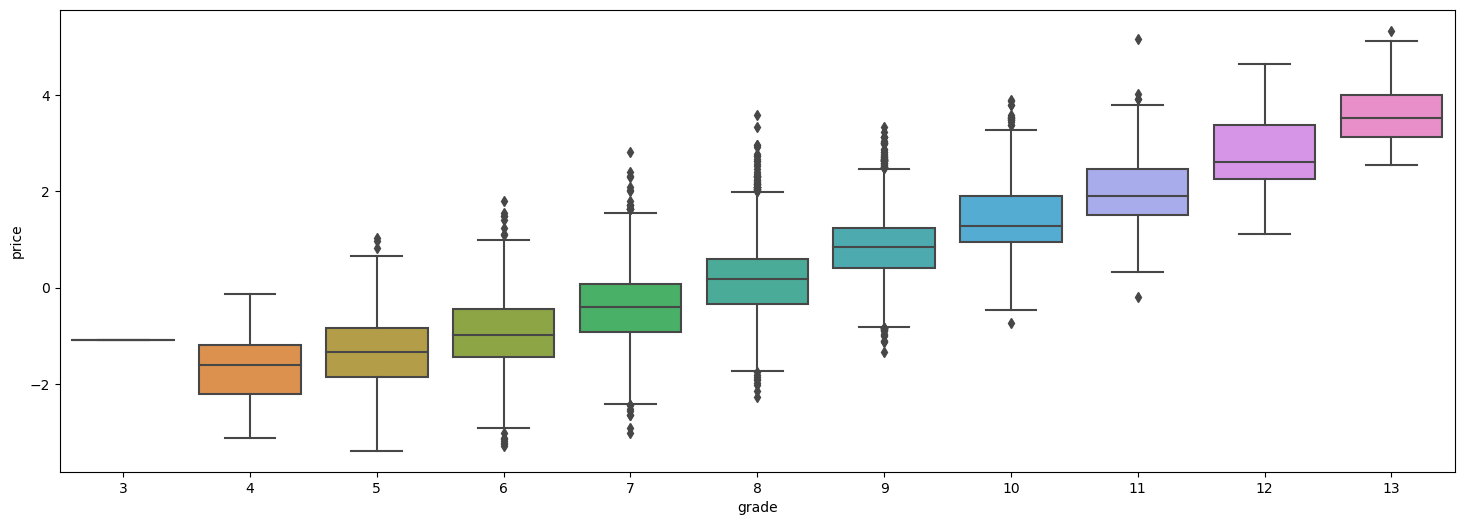

In [50]:
#Box plot for grade
var = 'grade'
data = pd.concat([df['price'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x=var, y="price", data=data)

Grade shows a strong relationship with the price as the higher the grade goes the stronger an impact it has on the price.

## Dummy Variables

The purpose of creating dummy variables is to convert categorical or discrete data into a format that can be easily incorporated into regression models, machine learning algorithms, or other statistical analyses.

By converting categorical variables into binary (0 or 1) format, you enable the model to consider these variables as factors that can influence the target variable (in this case, house prices). It's a crucial step in feature engineering, allowing the model to take into account the impact of different categories within these features on the target variable.

Creating dummy variables is essential for incorporating these categorical features into your analysis, enabling you to explore the relationships between these categories and house prices more effectively.


In [51]:
#Creating dummy variables
cond_dummies=pd.get_dummies(df.condition, prefix='cond')
floors_dummies=pd.get_dummies(df.floors, prefix='floor')
zipcode_dummies=pd.get_dummies(df.zipcode, prefix='zip')
grade_dummies=pd.get_dummies(df.grade, prefix='grade')
bed_dummies=pd.get_dummies(df.bedrooms, prefix='bed')
bath_dummies=pd.get_dummies(df.bathrooms, prefix='bath')

In [52]:
#Drop one dummy per variable
zipcode_dummies.drop(['zip_98039'], axis = 1, inplace = True)
cond_dummies.drop(['cond_1'], axis = 1, inplace = True)
floors_dummies.drop(['floor_3.0'], axis = 1, inplace = True)
grade_dummies.drop(['grade_3'], axis = 1, inplace = True)
bed_dummies.drop(['bed_11'], axis = 1, inplace = True)
bath_dummies.drop(['bath_8.0'], axis = 1, inplace = True)

In [53]:
df_categorical = pd.concat([zipcode_dummies, grade_dummies, bed_dummies, bath_dummies], axis=1)

In [54]:
df_categorical = pd.concat([zipcode_dummies, grade_dummies, bed_dummies, bath_dummies], axis=1)

df_categorical = df_categorical.astype(int)


In [55]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19220 entries, 1 to 21596
Columns: 117 entries, zip_98001 to bath_7.75
dtypes: int32(117)
memory usage: 9.2 MB


## Preparing Numerical Data

In [56]:
df_numerical=pd.concat([df.sqft_living,df.sqft_living15,df.sqft_lot,df.sqft_lot15,df.yr_built,df.sqft_basement,df.sqft_above], axis=1)

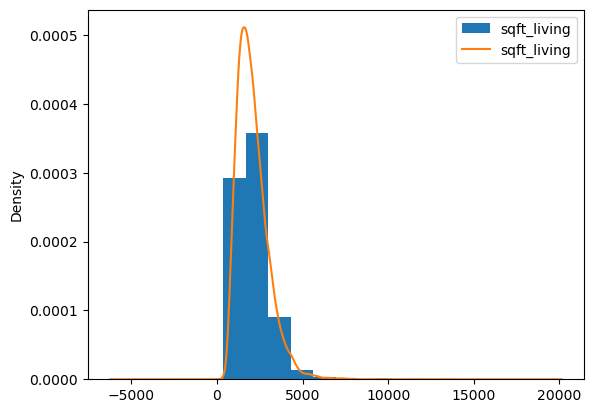

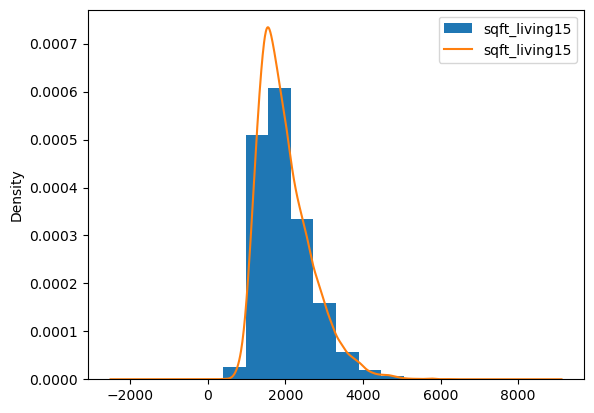

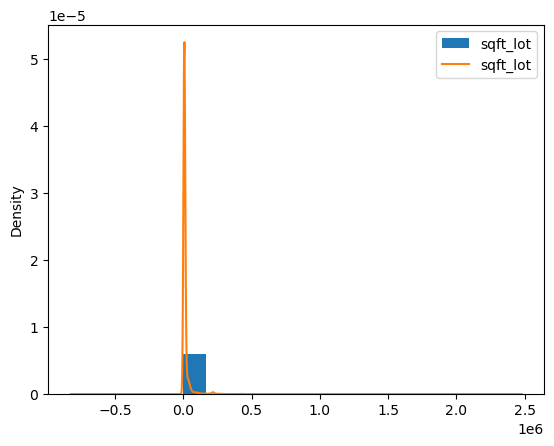

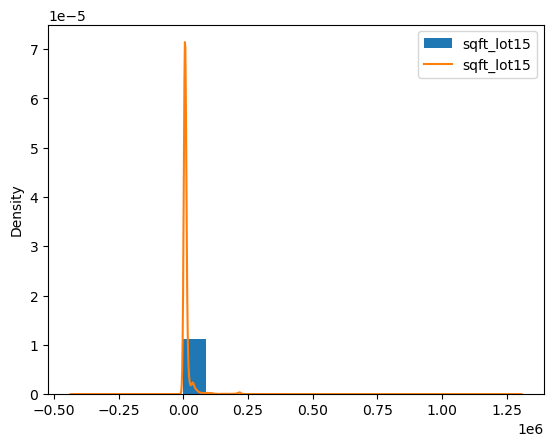

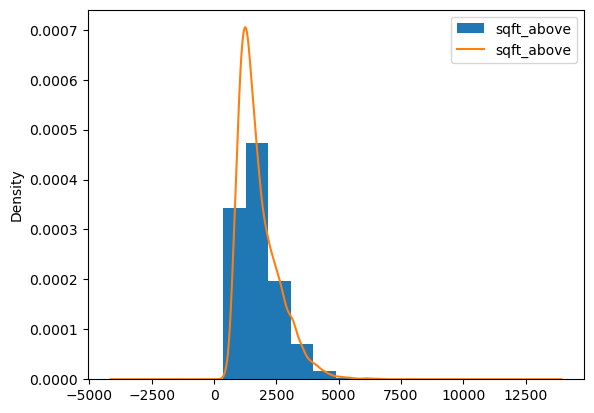

In [57]:
for column in ['sqft_living',
       'sqft_living15', 'sqft_lot', 'sqft_lot15','sqft_above']:
    df[column].plot.hist(density=True )
    df[column].plot.kde(label=column )
    plt.legend()
    plt.show()

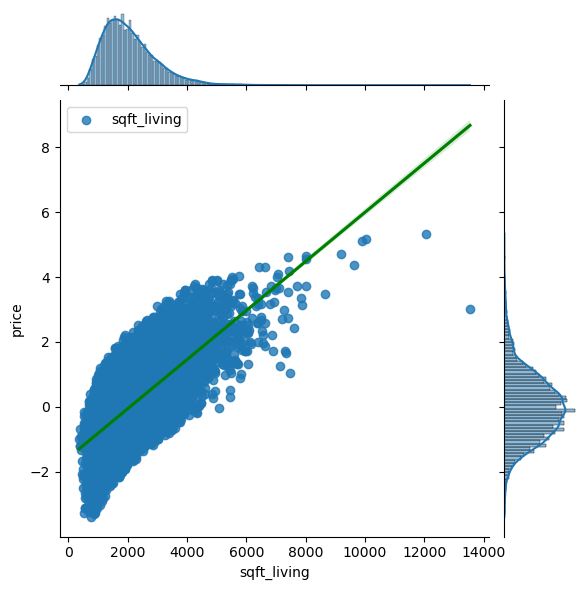

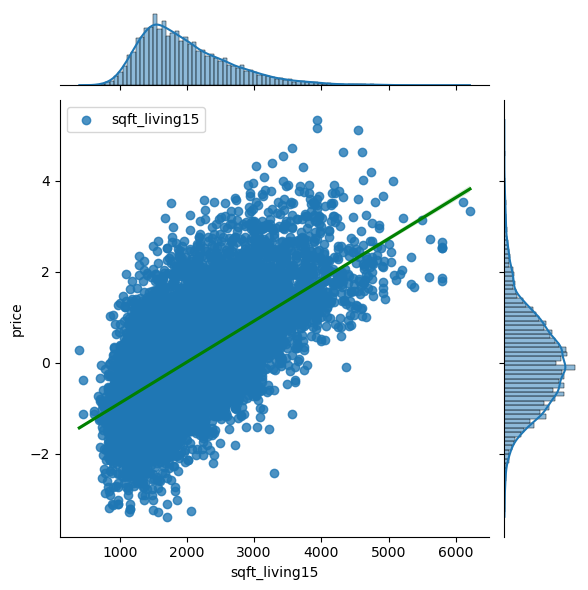

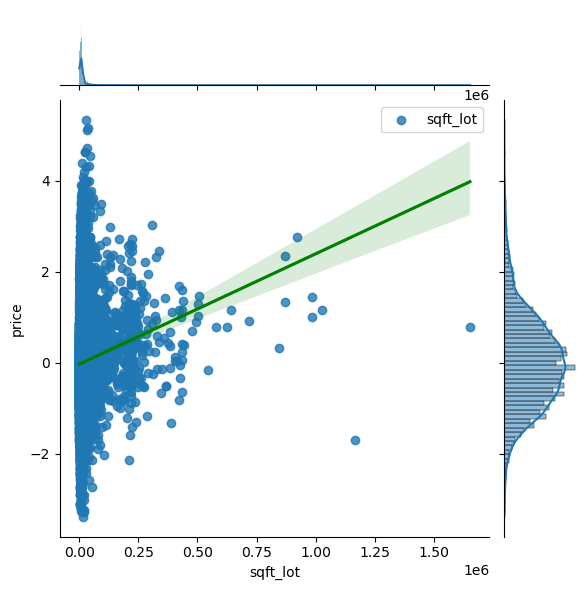

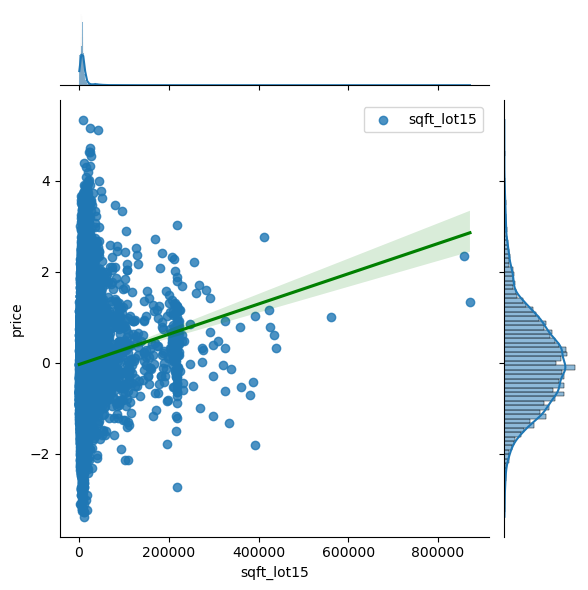

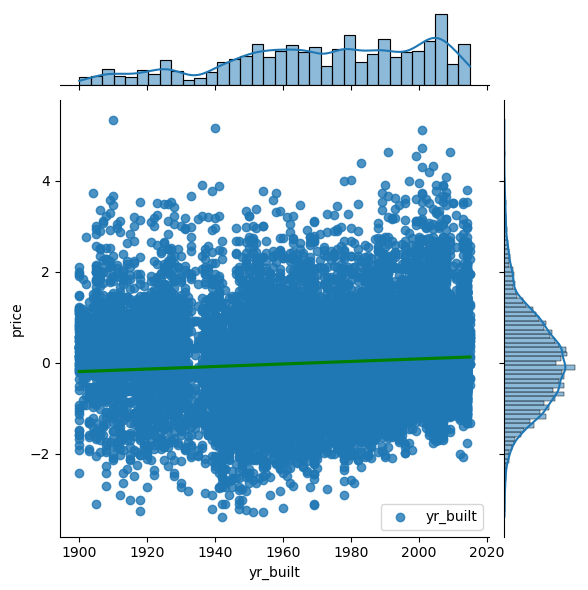

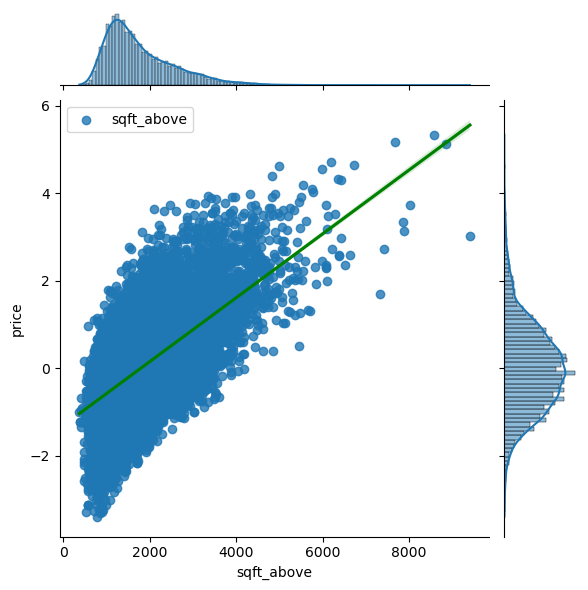

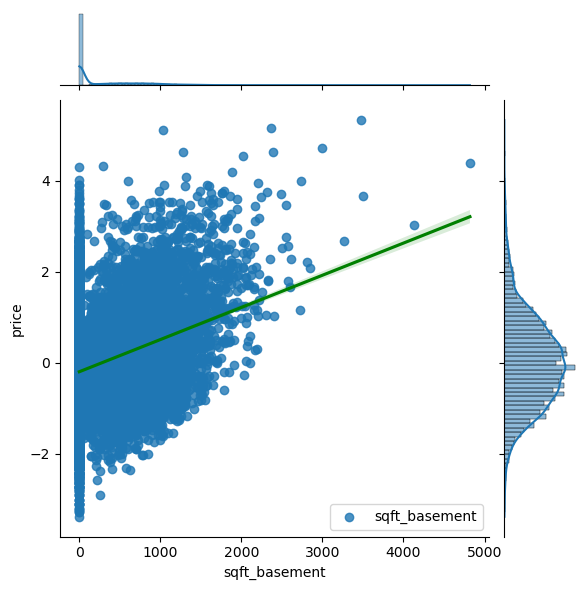

In [58]:
for column in ['sqft_living','sqft_living15', 'sqft_lot', 'sqft_lot15','yr_built','sqft_above', 'sqft_basement']:
    sns.jointplot(x=column, y="price",
                  data=df, 
                  kind='reg', 
                  label=column,
                  joint_kws={'line_kws':{'color':'green'}})
    plt.legend()
    plt.show()

Amoung the four highly correlated variables, sqft_living has the fewest outliers and the distribution that is closest to normal. It is therefore a favourable choice and the other two can be excluded. The skewness and kurtosis are also important in our study. sqft_lot variable displays heteroskedasticity and its basement values contain an excessive number of 0 values. yr_built can be considered as a time series variable. 

C:\Users\hp\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


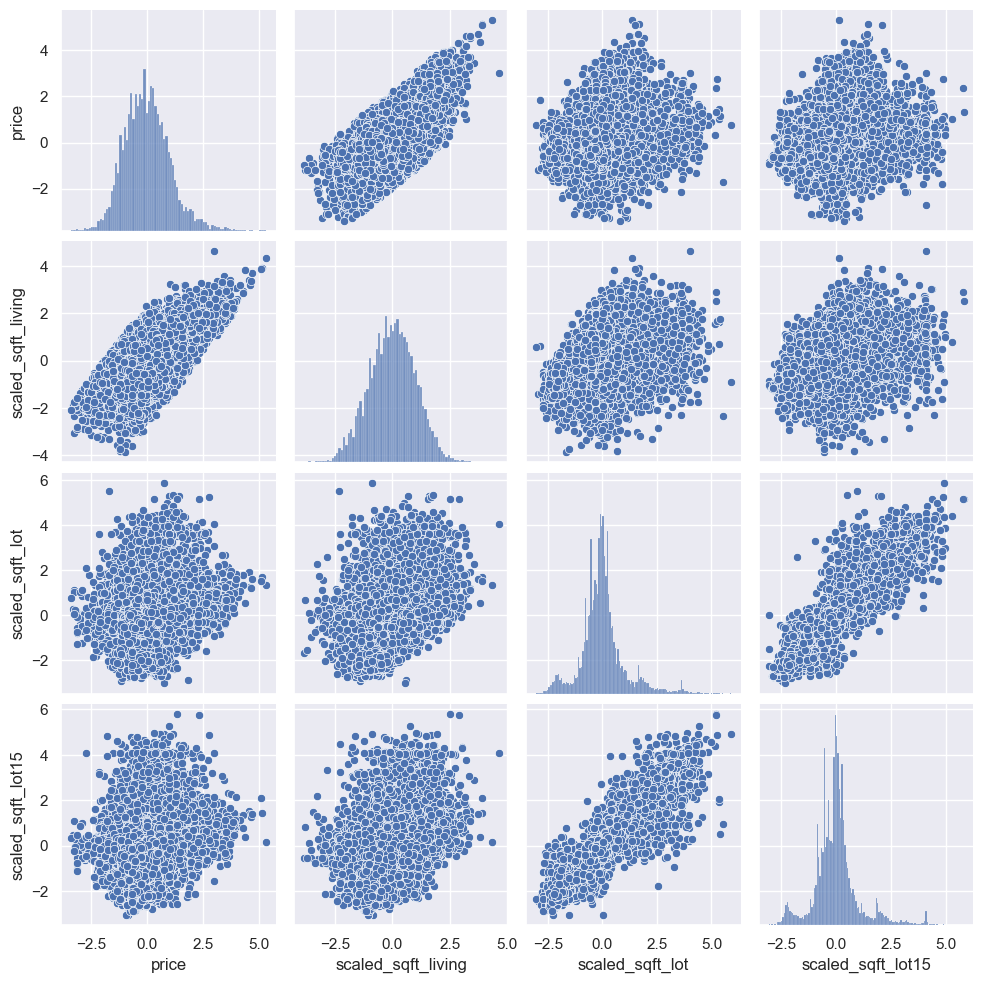

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'df' with columns 'price', 'sqft_living', 'sqft_lot', and 'sqft_lot15'

# Create a DataFrame with log-transformed variables
data_log = pd.DataFrame([])
data_log["log_sqft_living"] = np.log(df["sqft_living"])
data_log["log_sqft_lot"] = np.log(df["sqft_lot"])
data_log["log_sqft_lot15"] = np.log(df["sqft_lot15"])

# Standardize the log-transformed variables
sqftlot = data_log["log_sqft_lot"]
sqftliving = data_log["log_sqft_living"]
sqftlot15 = data_log["log_sqft_lot15"]

scaled_sqftliving = (sqftliving - sqftliving.mean()) / sqftliving.std()
scaled_sqftlot = (sqftlot - sqftlot.mean()) / sqftlot.std()
scaled_sqftlot15 = (sqftlot15 - sqftlot15.mean()) / sqftlot15.std()

# Create a combined numerical DataFrame
df_combined = pd.concat([df["price"], scaled_sqftliving, scaled_sqftlot, scaled_sqftlot15], axis=1)
df_combined.columns = ['price', 'scaled_sqft_living', 'scaled_sqft_lot', 'scaled_sqft_lot15']

# Create a pairplot for the selected columns
sns.set()
cols = ['price', 'scaled_sqft_living', 'scaled_sqft_lot', 'scaled_sqft_lot15']
sns.pairplot(df_combined[cols], height=2.5)
plt.show()


The size of living area is the strongest numerical predictor. Size and existence of basement does show a linear relationship tp price despite many zero values. sqft_living and sqft_above are removed because the correlations matrix and multicollinearity. 

In [60]:
df_numerical.describe()

,sqft_living,sqft_living15,sqft_lot,sqft_lot15,yr_built,sqft_basement,sqft_above
count,19220.000000,19220.000000,1.922000e+04,19220.000000,19220.000000,19220.000000,19220.000000
mean,2082.444953,1987.410146,1.507423e+04,12807.113892,1971.041051,284.825754,1791.405151
std,922.562829,684.725375,4.081830e+04,27577.497800,29.384919,439.984542,831.731558
min,370.000000,399.000000,5.200000e+02,651.000000,1900.000000,0.000000,370.000000
25%,1430.000000,1490.000000,5.040000e+03,5100.000000,1951.000000,0.000000,1200.000000
50%,1920.000000,1840.000000,7.620000e+03,7620.000000,1975.000000,0.000000,1560.000000
75%,2550.000000,2360.000000,1.071700e+04,10092.000000,1997.000000,540.000000,2220.000000
max,13540.000000,6210.000000,1.651359e+06,871200.000000,2015.000000,4820.000000,9410.000000


In [61]:
df_numerical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19220 entries, 1 to 21596
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sqft_living    19220 non-null  int64  
 1   sqft_living15  19220 non-null  int64  
 2   sqft_lot       19220 non-null  int64  
 3   sqft_lot15     19220 non-null  int64  
 4   yr_built       19220 non-null  float64
 5   sqft_basement  19220 non-null  float64
 6   sqft_above     19220 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 1.7 MB


In [62]:
df_numerical['yr_built'] = df_numerical['yr_built'].astype(int)
df_numerical['sqft_basement'] = df_numerical['sqft_basement'].astype(int)

In [63]:
df_numerical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19220 entries, 1 to 21596
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   sqft_living    19220 non-null  int64
 1   sqft_living15  19220 non-null  int64
 2   sqft_lot       19220 non-null  int64
 3   sqft_lot15     19220 non-null  int64
 4   yr_built       19220 non-null  int32
 5   sqft_basement  19220 non-null  int32
 6   sqft_above     19220 non-null  int64
dtypes: int32(2), int64(5)
memory usage: 1.5 MB


## Modelling

### Model 1

For the first multiple regression model, we'll include the two variables that had the highest correlations with price without violating the multicollinearity assumption:

In [64]:
X = df[['sqft_living', 'sqft_above']]

# Add a constant term to the model (intercept)
X = sm.add_constant(X)

# Define the dependent variable
y = df['price']

# Fit the multiple regression model
model = sm.OLS(y, X).fit()

# Get the summary of the regression analysis
model_summary = model.summary()

# Print the regression summary
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     9077.
Date:                Thu, 26 Oct 2023   Prob (F-statistic):               0.00
Time:                        02:54:58   Log-Likelihood:                -20911.
No. Observations:               19220   AIC:                         4.183e+04
Df Residuals:                   19217   BIC:                         4.185e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.5684      0.013   -121.323      

Here are the observations based on the results:

R-squared Value: The R-squared value is 0.486. This indicates that approximately 48.6% of the variation in house prices is explained by the square meter of living space. In other words, the model with this single independent variable is moderately effective in explaining the variation in house prices.

F-statistic: The F-statistic is 1.814e+04. This statistic is used to test the overall significance of the regression model. A high F-statistic value suggests that the model is statistically significant, which is the case here. It means that at least one of the independent variables (in this case, 'sqmt_living') is related to the dependent variable ('price').
Coefficients: The coefficient for the constant (intercept) is approximately -1.5730. This is the estimated house price when the square meter of living space is zero. In this context, it doesn't have a practical interpretation.
The coefficient for 'sqmt_living' is approximately 0.0081. It indicates that, on average, for every additional square meter of living space, the house price increases by 0.0081 units.
P-values: The p-values associated with both the intercept and 'sqmt_living' are very close to zero (0.000). Low p-values indicate that both variables are statistically significant in predicting house prices.

The model indicates that square meter of living space ('sqmt_living') is a significant predictor of house prices, and for each additional square meter of living space, the house price increases by 0.0081 units. However, it's important to consider the specific context of the data and the assumptions of the regression model when interpreting these results. Additionally, this model uses only one independent variable to predict house prices, and there may be other important factors that contribute to price variation.

### Model 2

To improve the model, we implement different regression techniques, feature engineering, and feature selection methods.
We will use feature selection with Recursive Feature Elimination (RFE) from the scikit-learn library. This technique will recursively remove the least important features from the model until the desired number of features is reached. We aim to improve the model by selecting the best features.

In [65]:
import statsmodels.api as sm
import pandas as pd

# Assuming you've already defined 'df_numerical' and 'df_categorical' as lists of column names
# Create separate DataFrames for numerical and categorical features
X_numerical = df[df_numerical]
X_categorical = df[df_categorical]

# Add a constant term (intercept) to both DataFrames
X_numerical = sm.add_constant(X_numerical)
X_categorical = sm.add_constant(X_categorical)

# Concatenate the two DataFrames if needed
X = pd.concat([X_numerical, X_categorical], axis=1)

# Define the dependent variable
y = df['price']

# Fit the multiple regression model
model = sm.OLS(y, X).fit()

# Get the summary of the regression analysis
model_summary = model.summary()

# Print the regression summary
print(model_summary)


ValueError: Boolean array expected for the condition, not int64

In [66]:
X = df[['sqft_living', 'sqft_above','zipcode','bathrooms', 'condition', 'bedrooms', 'sqft_living15', 'floors','grade','yr_built', 'sqft_lot', 'sqft_basement']]

# Add a constant term to the model (intercept)
X = sm.add_constant(X)

# Define the dependent variable
y = df['price']

# Fit the multiple regression model
model = sm.OLS(y, X).fit()

# Get the summary of the regression analysis
model_summary = model.summary()

# Print the regression summary
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     2948.
Date:                Thu, 26 Oct 2023   Prob (F-statistic):               0.00
Time:                        02:58:13   Log-Likelihood:                -17266.
No. Observations:               19220   AIC:                         3.456e+04
Df Residuals:                   19207   BIC:                         3.466e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -69.1575      9.062     -7.632

In [67]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Create a linear regression model
model = LinearRegression()

# Specify the number of features you want to select
num_features_to_select = 80 # Adjust this number as needed

# Initialize the RFE model
rfe = RFE(estimator=model, n_features_to_select=num_features_to_select)

# Fit the RFE model to your data
X_rfe = rfe.fit_transform(X, y)  # X is your feature matrix, y is your target variable

# Get the selected feature indices
selected_features = rfe.support_

# Print the selected features
print("Selected features:")
print(X.columns[selected_features])



Selected features:
Index(['const', 'sqft_living', 'sqft_above', 'zipcode', 'bathrooms',
       'condition', 'bedrooms', 'sqft_living15', 'floors', 'grade', 'yr_built',
       'sqft_lot', 'sqft_basement'],
      dtype='object')


In [68]:
# Add a constant term to the X_rfe for the intercept
X_rfe = sm.add_constant(X_rfe)

# Fit the OLS model
model = sm.OLS(df["price"], X_rfe).fit()

# Display the OLS regression results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     2948.
Date:                Thu, 26 Oct 2023   Prob (F-statistic):               0.00
Time:                        02:58:38   Log-Likelihood:                -17266.
No. Observations:               19220   AIC:                         3.456e+04
Df Residuals:                   19207   BIC:                         3.466e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -69.1575      9.062     -7.632      0.0

 Here are some observations based on the results:

R-squared (R^2): The R-squared value is 0.648, indicating that the model explains approximately 64.8% of the variance in the target variable (price). This suggests that the selected features have a reasonably good explanatory power.

Adjusted R-squared: The adjusted R-squared is also 0.648, which adjusts the R-squared value based on the number of features. It is slightly lower than R-squared, as expected when more features are included.
-statistic: The F-statistic tests the overall significance of the model. With a very high F-statistic of 1459 and a p-value close to zero, it suggests that the model is statistically significant.

Coefficients (coef): The coefficients represent the estimated impact of each feature on the target variable. For example, x1, x2, x3, etc., are the selected features, and their corresponding coefficients indicate the estimated change in price associated with a one-unit change in the feature. Negative coefficients suggest a negative relationship, while positive coefficients indicate a positive relationship.

P-values (P>|t|): The p-values associated with each coefficient test the null hypothesis that the coefficient is equal to zero. A low p-value (typically below 0.05) suggests that the feature is statistically significant in predicting the target variable.

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_rfe, df["price"], test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 0.35050840358102464


## Conclusion

Collectively, square footage, grade, and the number of bathrooms emerge as strong indicators of a house's price within King County. Individuals aspiring to maximize their property's value, dedicating efforts to enlarging the square footage and enhancing the overall construction quality is very important. When extending the square footage, it's advisable to contemplate the addition of extra bathrooms, as this analysis suggests a positive correlation between the number of bathrooms and the price.

Nonetheless, the model does possess certain constraints. It necessitated log-transforming some variables to meet regression assumptions, implying that any new data fed into the model would require similar preprocessing. Furthermore, given the regional disparities in housing prices, the model's generalizability to data from other counties may be constrained. Eliminating outliers from the dataset might result in the model struggling to accurately predict properties with exceptionally high or low values.

In prospective analyses, it would be beneficial to investigate the most influential predictors of home prices outside of King County, as well as for properties with extraordinary price levels.